## Libraries

In [32]:
import os
import gdown
import zipfile 
import shutil

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

import matplotlib.animation as animation
from IPython.display import HTML

## Config

In [42]:
dataset_root_dir = "data/celeba"
download_url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
download_path = f'{dataset_root_dir}/img_align_celeba.zip'

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
image_size = 64
num_workers = 2

num_channels = 3
z_size = 100
generator_feature_map_size = 64
discriminator_feature_map_size = 64

num_gpu = 1

num_epochs = 5
lr = 0.00008
beta1 = 0.5

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Download/Setup Dataset

In [9]:
if not os.path.exists(dataset_root_dir):
  os.makedirs(dataset_root_dir)

In [10]:
gdown.download(download_url, download_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip

0.00B [00:00, ?B/s]
4.72MB [00:00, 28.3MB/s]
26.7MB [00:00, 38.3MB/s]
37.2MB [00:00, 47.2MB/s]
61.9MB [00:00, 62.3MB/s]
75.0MB [00:00, 72.9MB/s]
97.0MB [00:00, 91.0MB/s]
113MB [00:00, 96.3MB/s] 
127MB [00:00, 106MB/s] 
146MB [00:01, 122MB/s]
165MB [00:01, 137MB/s]
184MB [00:01, 148MB/s]
203MB [00:01, 159MB/s]
225MB [00:01, 172MB/s]
244MB [00:01, 167MB/s]
262MB [00:01, 162MB/s]
286MB [00:01, 179MB/s]
306MB [00:01, 155MB/s]
325MB [00:02, 164MB/s]
344MB [00:02, 170MB/s]
365MB [00:02, 180MB/s]
384MB [00:02, 141MB/s]
401MB [00:02, 130MB/s]
415MB [00:02, 133MB/s]
430MB [00:02, 109MB/s]
445MB [00:03, 112MB/s]
462MB [00:03, 45.2MB/s]
476MB [00:04, 56.5MB/s]
495MB [00:04, 61.7MB/s]
512MB [00:04, 75.1MB/s]
529MB [00:04, 76.6MB/s]
539MB [00:04, 65.7MB/s]
554MB [00:05, 66.9MB/s]
571MB [00:05, 71.7MB/s]
588MB [00:05, 82.9MB/s]
598MB [00:05, 84.9MB/s]
613MB [00:05, 94.

'data/celeba/img_align_celeba.zip'

In [11]:
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_root_dir)
os.remove(download_path)

## Dataset & Dataloader

In [44]:
dataset = torchvision.datasets.ImageFolder(root=dataset_root_dir, 
                                           transform=transforms.Compose([
                                             transforms.Resize(image_size),
                                             transforms.CenterCrop(image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

### Preview some images of the dataset

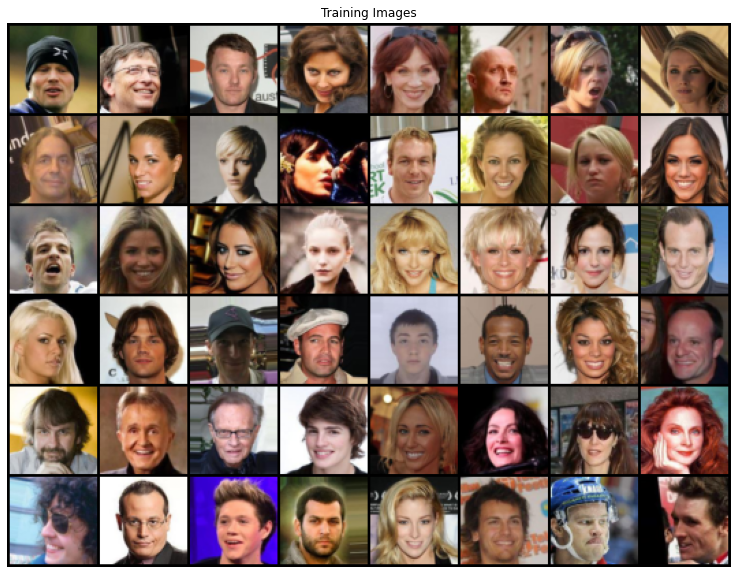

In [45]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:48].cpu(), padding=2, normalize=True), (1,2,0)));

## Implementation

### Weight Initialization

In [14]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

### Generator

In [36]:
class Generator(nn.Module):
  def __init__(self, num_gpu):
    super(Generator, self).__init__()
    self.num_gpu = num_gpu
    self.main = nn.Sequential(
        # Input: Z
        nn.ConvTranspose2d(z_size, generator_feature_map_size*8, 4, 1, 0, bias=False), # (generator_feature_map_size*8) x 4 x 4
        nn.BatchNorm2d(generator_feature_map_size*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(generator_feature_map_size*8, generator_feature_map_size*4, 4, 2, 1, bias=False), # (generator_feature_map_size*4) x 8 x 8
        nn.BatchNorm2d(generator_feature_map_size*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(generator_feature_map_size*4, generator_feature_map_size*2, 4, 2, 1, bias=False), # (generator_feature_map_size*2) x 16 x 16
        nn.BatchNorm2d(generator_feature_map_size*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(generator_feature_map_size*2, generator_feature_map_size, 4, 2, 1, bias=False), # (generator_feature_map_size) x 32 x 32
        nn.BatchNorm2d(generator_feature_map_size),
        nn.ReLU(True),
        nn.ConvTranspose2d(generator_feature_map_size, num_channels, 4, 2, 1, bias=False), # (num_channels) x 64 x 64
        nn.Tanh()
    )
  
  def forward(self, input):
    return self.main(input)

In [46]:
generator_net = Generator(num_gpu).to(device)
generator_net.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Discriminator

In [17]:
class Discriminator(nn.Module):
  def __init__(self, num_gpu):
    super(Discriminator, self).__init__()
    self.num_gpu = num_gpu
    self.main = nn.Sequential(
        # input: num_channels x 64 x 64
        nn.Conv2d(num_channels, discriminator_feature_map_size, 4, 2, 1, bias=False), # discriminator_feature_map_size x 32 x 32 ((64 - 4 + 2*1)/2 + 1 = 32)
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(discriminator_feature_map_size, discriminator_feature_map_size*2, 4, 2, 1, bias=False), # (discriminator_feature_map_size*2) x 16 x 16
        nn.BatchNorm2d(discriminator_feature_map_size*2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(discriminator_feature_map_size*2, discriminator_feature_map_size*4, 4, 2, 1, bias=False), # (discriminator_feature_map_size*4) x 8 x 8
        nn.BatchNorm2d(discriminator_feature_map_size*4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(discriminator_feature_map_size*4, discriminator_feature_map_size*8, 4, 2, 1, bias=False), # (discriminator_feature_map_size*8) x 4 x 4
        nn.BatchNorm2d(discriminator_feature_map_size*8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(discriminator_feature_map_size*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  
  def forward(self, input):
    return self.main(input)

In [47]:
discriminator_net = Discriminator(num_gpu).to(device)
discriminator_net.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Loss Function and Optimizer

In [48]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, z_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizer_discriminator = optim.Adam(discriminator_net.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_generator = optim.Adam(generator_net.parameters(), lr=lr, betas=(beta1, 0.999))

## Training 

In [49]:
img_list = []
generator_losses = []
discriminator_losses = []
iters = 0

for epoch in range(num_epochs):
  for i, (real_images, _) in enumerate(dataloader, 0):
    # 1) Update Discriminator
    # 1.1 - Train with real images
    optimizer_discriminator.zero_grad()
    
    real_images = real_images.to(device)

    current_batch_size = real_images.shape[0]
    label = torch.full((current_batch_size,), real_label, dtype=torch.float, device=device)

    output = discriminator_net(real_images).view(-1)

    discriminator_real_err = criterion(output, label)
    discriminator_real_err.backward()
    
    D_x = output.mean().item()
    
    # 1.2 - Train with fake images
    noise = torch.rand(current_batch_size, z_size, 1, 1, device=device)

    fake_images = generator_net(noise)

    label.fill_(fake_label)

    output = discriminator_net(fake_images.detach()).view(-1)

    discriminator_fake_err = criterion(output, label)
    discriminator_fake_err.backward()    

    D_G_z1 = output.mean().item()    

    discriminator_err = discriminator_real_err + discriminator_fake_err

    optimizer_discriminator.step()


    # 2) Update Generator
    optimizer_generator.zero_grad()

    label.fill_(real_label)

    output = discriminator_net(fake_images).view(-1)

    generator_err = criterion(output, label)
    generator_err.backward()

    D_G_z2 = output.mean().item()

    optimizer_generator.step()

    if i % 50 == 0:
      print(f"[{epoch}/{num_epochs}] [{i}/{len(dataloader)}]\tLoss_D: {'%.4f' % discriminator_err.item()}\tLoss_G: {'%.4f' % generator_err.item()}\tD(x): {'%.4f' % D_x}\tD(G(z)): {'%.4f' % D_G_z1} / {'%.4f' % D_G_z2}")
      
    generator_losses.append(generator_err.item())
    discriminator_losses.append(discriminator_err.item())

    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake_images = generator_net(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
      
    iters += 1

[0/5] [0/1583]	Loss_D: 1.8709	Loss_G: 4.6126	D(x): 0.2885	D(G(z)): 0.3187 / 0.0138
[0/5] [50/1583]	Loss_D: 1.5192	Loss_G: 7.7858	D(x): 0.6838	D(G(z)): 0.4702 / 0.0005
[0/5] [100/1583]	Loss_D: 0.8394	Loss_G: 7.1072	D(x): 0.7929	D(G(z)): 0.2869 / 0.0010
[0/5] [150/1583]	Loss_D: 0.5003	Loss_G: 6.4773	D(x): 0.8486	D(G(z)): 0.1454 / 0.0016
[0/5] [200/1583]	Loss_D: 0.4239	Loss_G: 6.3417	D(x): 0.8872	D(G(z)): 0.1470 / 0.0018
[0/5] [250/1583]	Loss_D: 0.2347	Loss_G: 5.8407	D(x): 0.9360	D(G(z)): 0.1052 / 0.0030
[0/5] [300/1583]	Loss_D: 0.2233	Loss_G: 5.6465	D(x): 0.9324	D(G(z)): 0.0857 / 0.0038
[0/5] [350/1583]	Loss_D: 0.0969	Loss_G: 5.9282	D(x): 0.9761	D(G(z)): 0.0465 / 0.0028
[0/5] [400/1583]	Loss_D: 0.0794	Loss_G: 5.2653	D(x): 0.9786	D(G(z)): 0.0419 / 0.0054
[0/5] [450/1583]	Loss_D: 0.0491	Loss_G: 5.7964	D(x): 0.9822	D(G(z)): 0.0238 / 0.0034
[0/5] [500/1583]	Loss_D: 0.0855	Loss_G: 5.2278	D(x): 0.9679	D(G(z)): 0.0122 / 0.0056
[0/5] [550/1583]	Loss_D: 0.0213	Loss_G: 5.7408	D(x): 0.9896	D(G(z)):

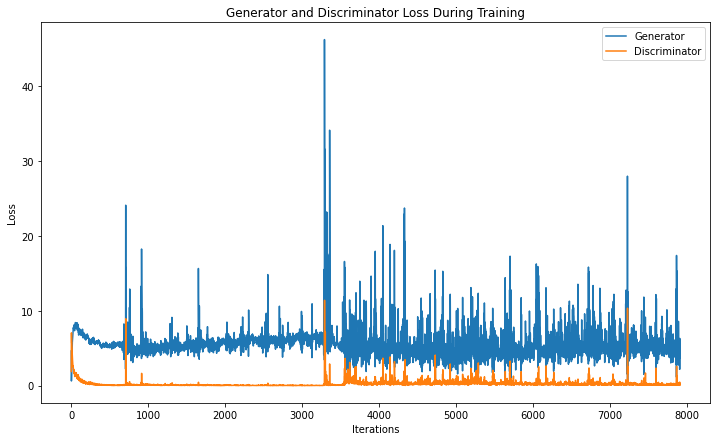

In [50]:
plt.figure(figsize=(12, 7))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="Generator")
plt.plot(discriminator_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend();

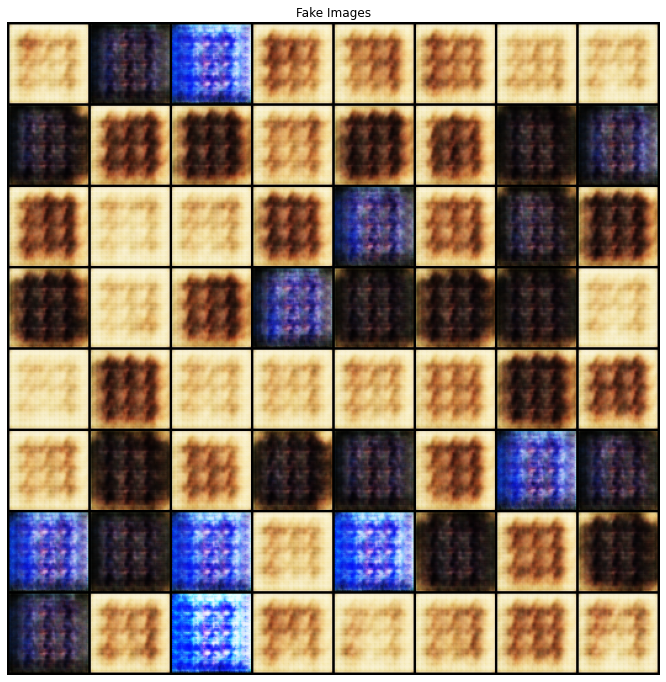

In [74]:
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)));

:| Needs to be fixed!!!

## Resources
- [https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
- [https://stackoverflow.com/questions/65528568/how-do-i-load-the-celeba-dataset-on-google-colab-using-torch-vision-without-ru](https://stackoverflow.com/questions/65528568/how-do-i-load-the-celeba-dataset-on-google-colab-using-torch-vision-without-ru)
